# Simulated one-dimensional latent space

In [1]:
import string
import pandas as pd

from itertools import combinations
from gpytorch.kernels import RQKernel
import torch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Simulate data

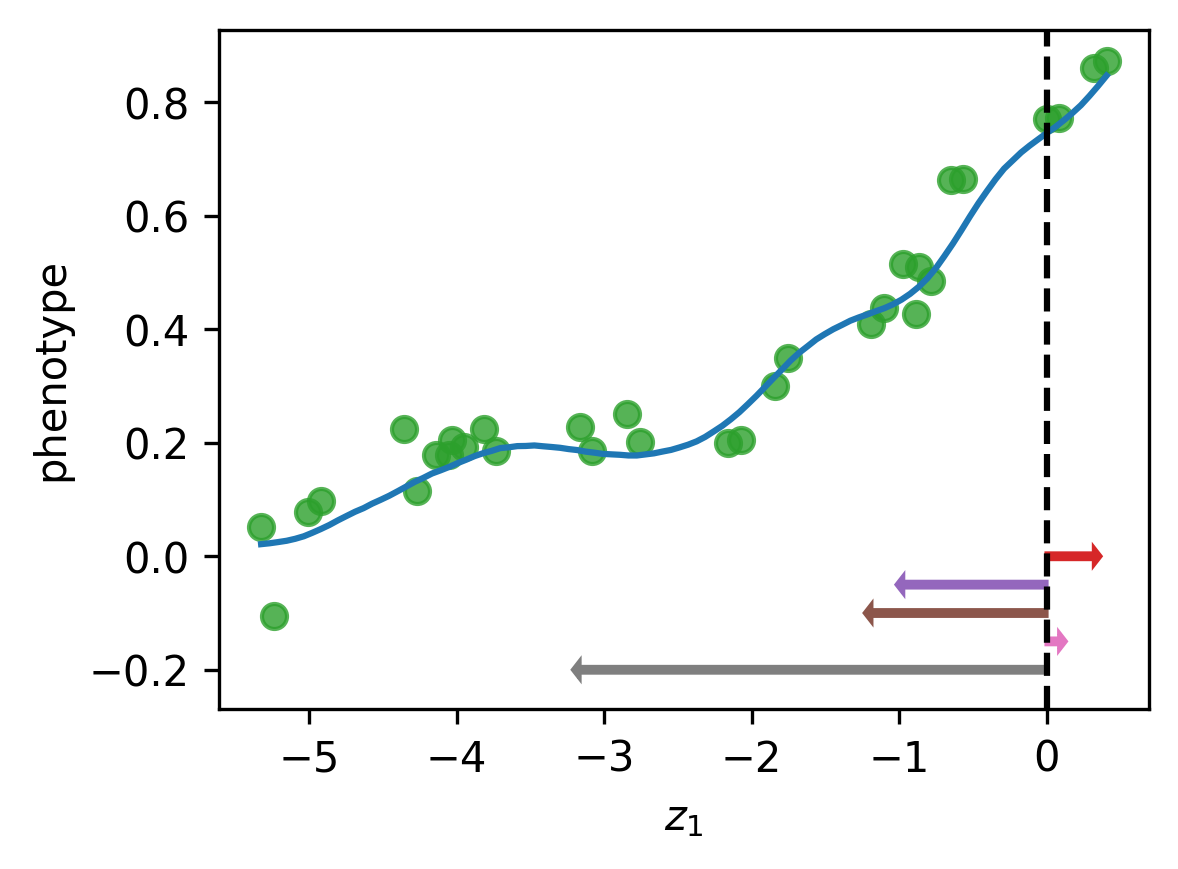

In [2]:
def sim(seed, p=5):

    N = 2 ** p
    torch.random.manual_seed(seed)
    W = (torch.randn(p, 1) - 0.2) * 2

    X = torch.zeros(N, p)
    ind = 1

    # for all # of mutations
    for mutations in range(1, p + 1):

        # for selected combination of mutations for a variant
        for variant in combinations(range(p), mutations):

            # for each selected
            for s in variant:
                X[ind, s] = 1

            # update after variant
            ind += 1

    z = torch.mm(X, W)
    Z = torch.linspace(z.min(), z.max(), 100)[:, None]
    z_samp = torch.cat((z, Z), 0)

    kernel = RQKernel()
    with torch.no_grad():
        K = kernel(z_samp).evaluate()
        f = torch.distributions.MultivariateNormal(
            torch.zeros(N + 100), 0.0025 * K + torch.eye(N + 100) * 1e-7
        ).rsample() + torch.sigmoid(0.9+ z_samp[:, 0])
        
    y = f[:N] + torch.randn(N) * 0.05

    return W, X, z, y, Z, f[N:]

p = 5
W, X, z, y, Z, f = sim(100, p=p)

plt.figure(figsize=(4, 3), dpi=300)
plt.plot(Z, f)
plt.scatter(z, y, c="C2", alpha=0.8)
plt.axvline(0, c="k", ls="--")

for i in range(p):
    plt.arrow(0, -.05*i, W[i].item(), 0, color=f"C{3+i}", width=0.01)
    
plt.ylabel("phenotype")
plt.xlabel("$z_1$")
    
None

### Convert to dataframe

We convert the generated dataset to a pandas DataFrame for use with LANTERN.

In [3]:
df = pd.DataFrame(
    {
        "substitutions": [
            ":".join(
                [
                    # encode each mutation as one of +a, +b, ...
                    "+{}".format(string.ascii_lowercase[i])
                    for i in np.where(X[j, :].numpy())[0]
                ]
            )
            for j in range(X.shape[0])
        ],
        "phenotype": ((y-y.mean())/y.std()).numpy(),
    },
)

df.head()

,substitutions,phenotype
0,,1.711029
1,+a,2.069441
2,+b,0.693510
3,+c,0.269302
4,+d,1.718302


### Build LANTERN dataset

In [4]:
from lantern.dataset import Dataset
ds = Dataset(df)
ds

Dataset(substitutions='substitutions', phenotypes=['phenotype'], errors=None)

In [5]:
# 32 observations
len(ds)

32

In [6]:
# get the first element (a tuple of x_0, y_0)
ds[0]

(tensor([0., 0., 0., 0., 0.]), tensor([1.7110]))

## Build model

In [7]:
K = 4

In [8]:
from lantern.model.basis import VariationalBasis

basis = VariationalBasis.fromDataset(ds, K=K)

In [9]:
from lantern.model.surface import Phenotype

surface = Phenotype.fromDataset(ds, K=K, Ni=200, inducScale=1.0)

In [10]:
from lantern.model import Model

model = Model(basis, surface)

## Train model

Text(0, 0.5, 'loss')

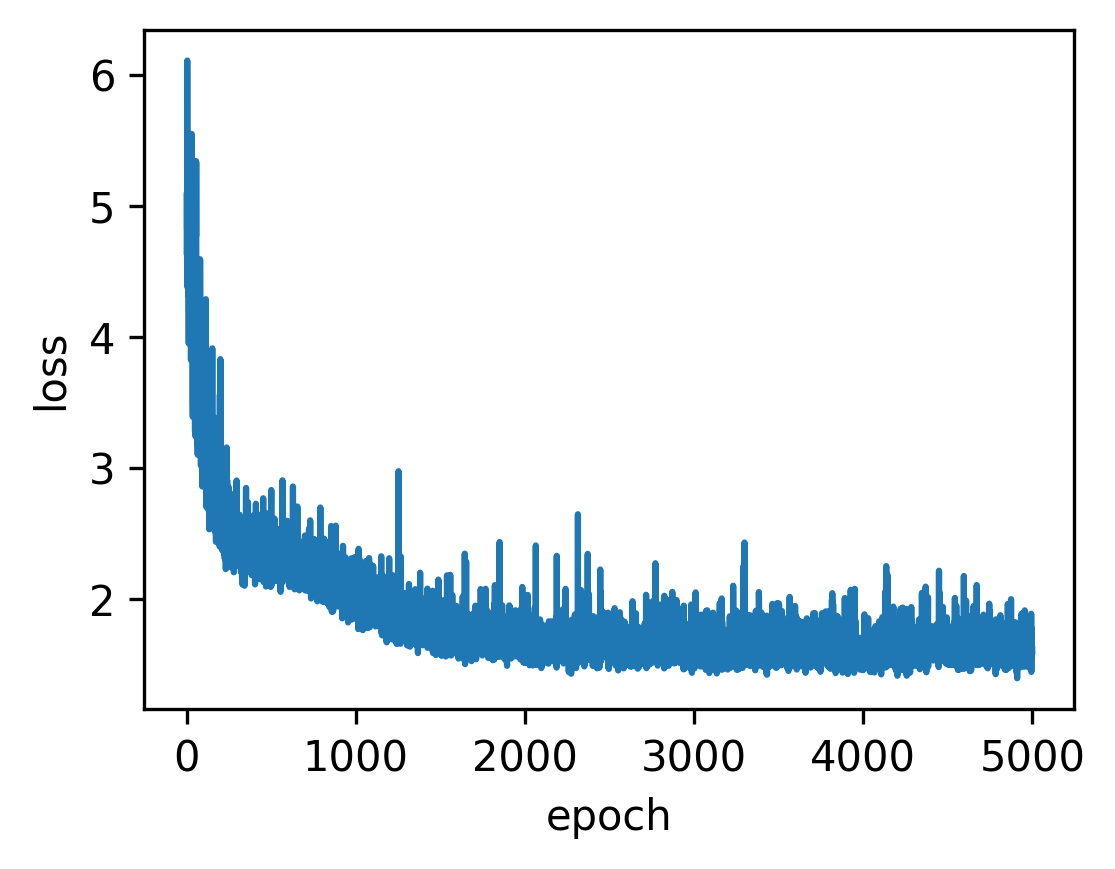

In [11]:
from torch.optim import Adam

loss = model.loss(N=len(ds))
Xtrain, ytrain = ds[: len(ds)]

E = 5000
optimizer = Adam(loss.parameters(), lr=0.01)
hist = []
halpha = np.zeros((E, K))

for i in range(E):
    
    optimizer.zero_grad()
    yhat = model(Xtrain)
    lss = loss(yhat, ytrain)
    total = sum(lss.values())
    total.backward()
    optimizer.step()
    # print(basis.log_alpha.grad.abs().max())
    
    hist.append(total.item())
    halpha[i, :] = basis.qalpha(detach=True).mean.numpy()
    

plt.figure(figsize=(4, 3), dpi=300)
plt.plot(hist)
plt.xlabel("epoch")
plt.ylabel("loss")

We also review the learned variance for each dimension at each iteration:

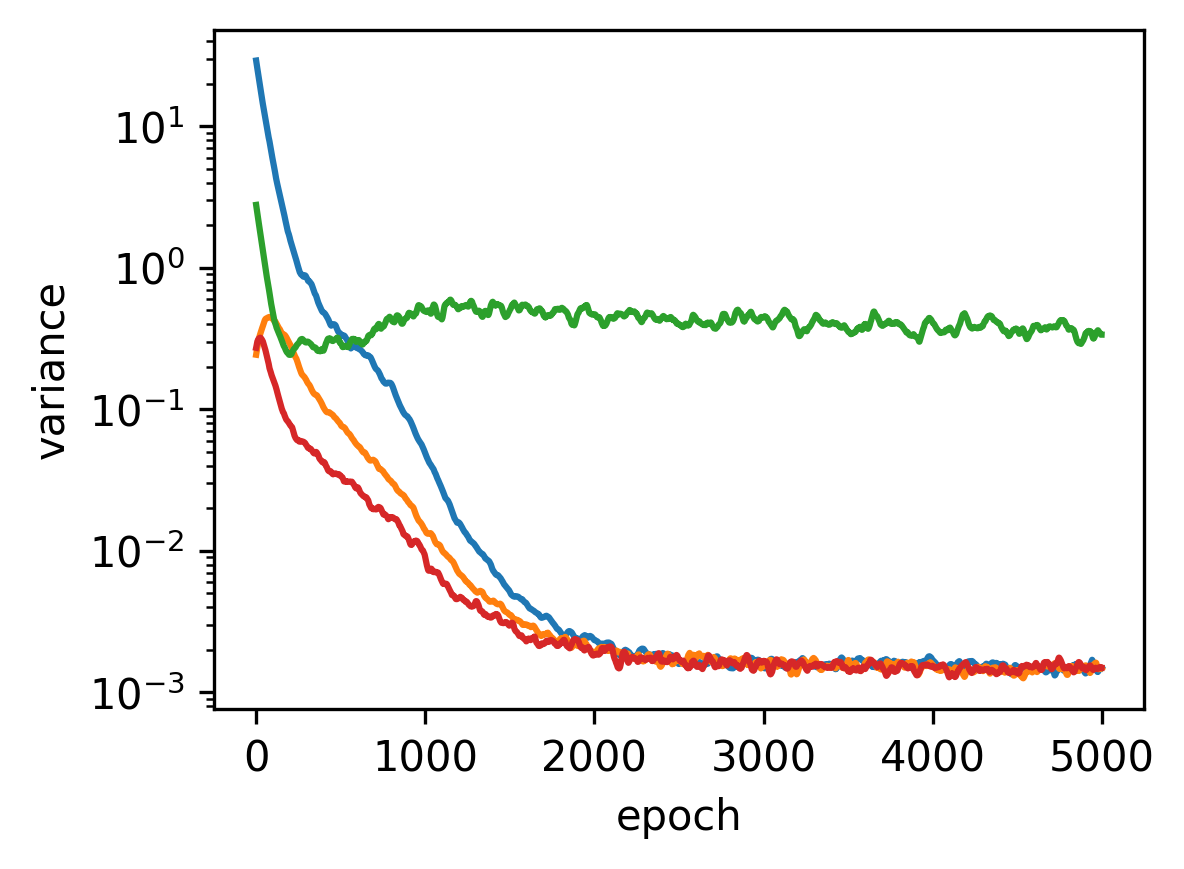

In [12]:
plt.figure(figsize=(4, 3), dpi=300)
plt.plot(1/halpha)
plt.xlabel("epoch")
plt.ylabel("variance")
plt.semilogy()

None

## Analyze model

### Model dimensionality

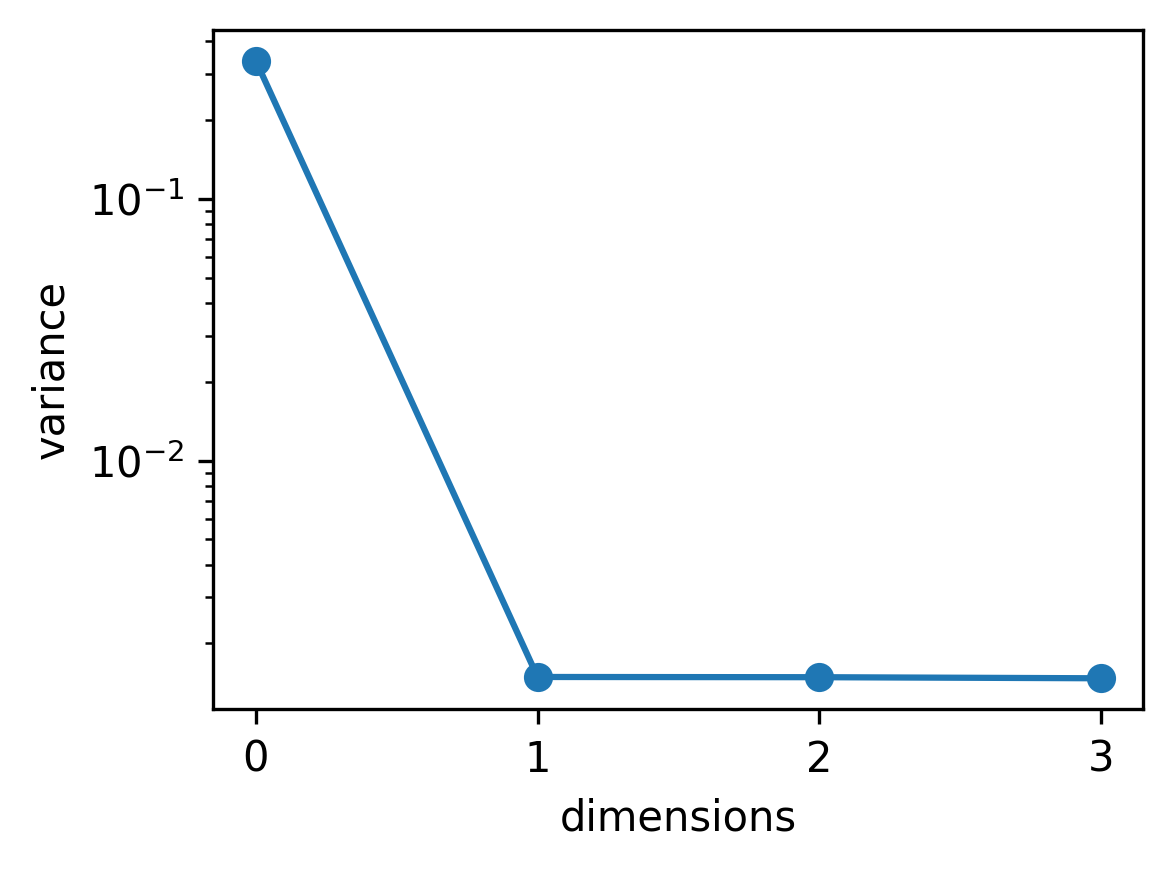

In [13]:
qa = 1/basis.qalpha(detach=True).mean[basis.order]

plt.figure(figsize=(4, 3), dpi=300)
plt.plot(qa)
plt.scatter(range(K), qa)

plt.xticks(range(K))
plt.semilogy()
plt.xlabel("dimensions")
plt.ylabel("variance")

None

The order of dimensions by relevance (e.g. their variance) is stochastic, and can change on different re-runs. We provide an `order` attribute on the `basis` component to address this problem. The `order` is the indexes of the latent dimensions sorted by their variance. We store the index of the highest relevance dimension here for further analysis.

In [14]:
z1 = basis.order[0]

### Compared learned latent effects

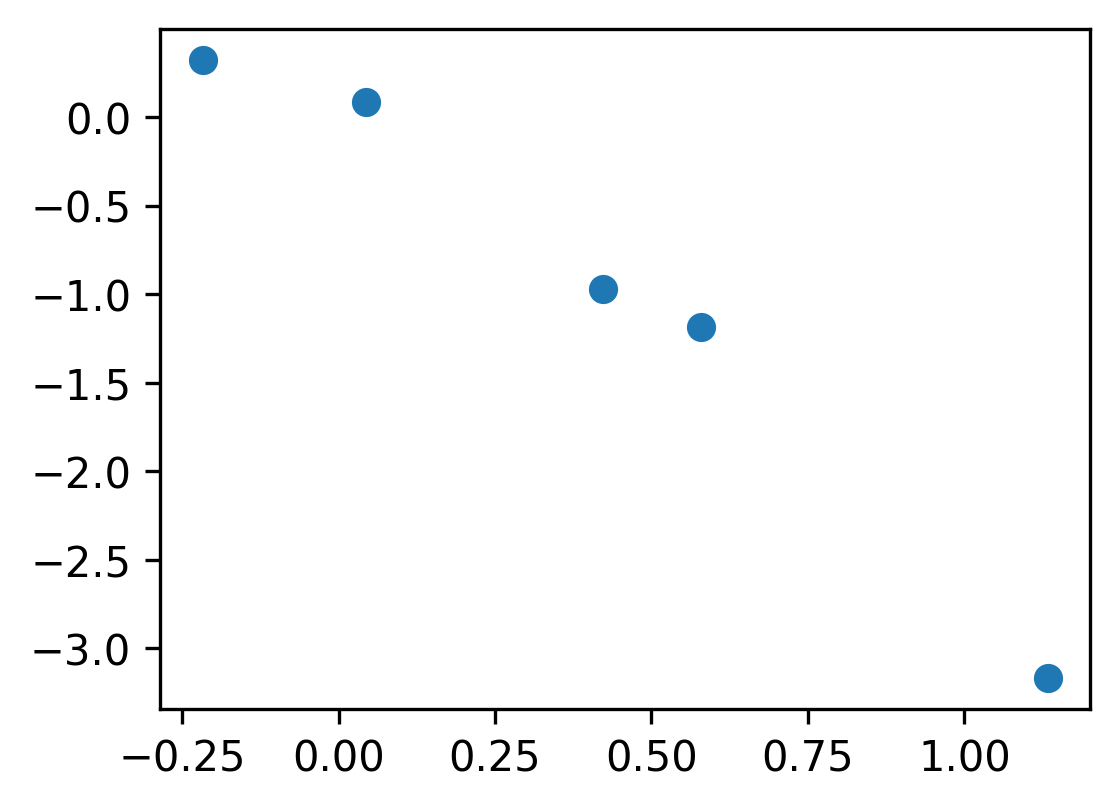

In [15]:
Wapprox = basis.W_mu[:, z1].detach().numpy()

plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(Wapprox, W)

None

### Plot learned surface

We compare the learned surface to the true, underlying surface. Since LANTERN is unaware of the underlying scale of the latent mutational effect dimension, we rescale the true $z_1$ to match that of the $z_1$ learned by LANTERN.

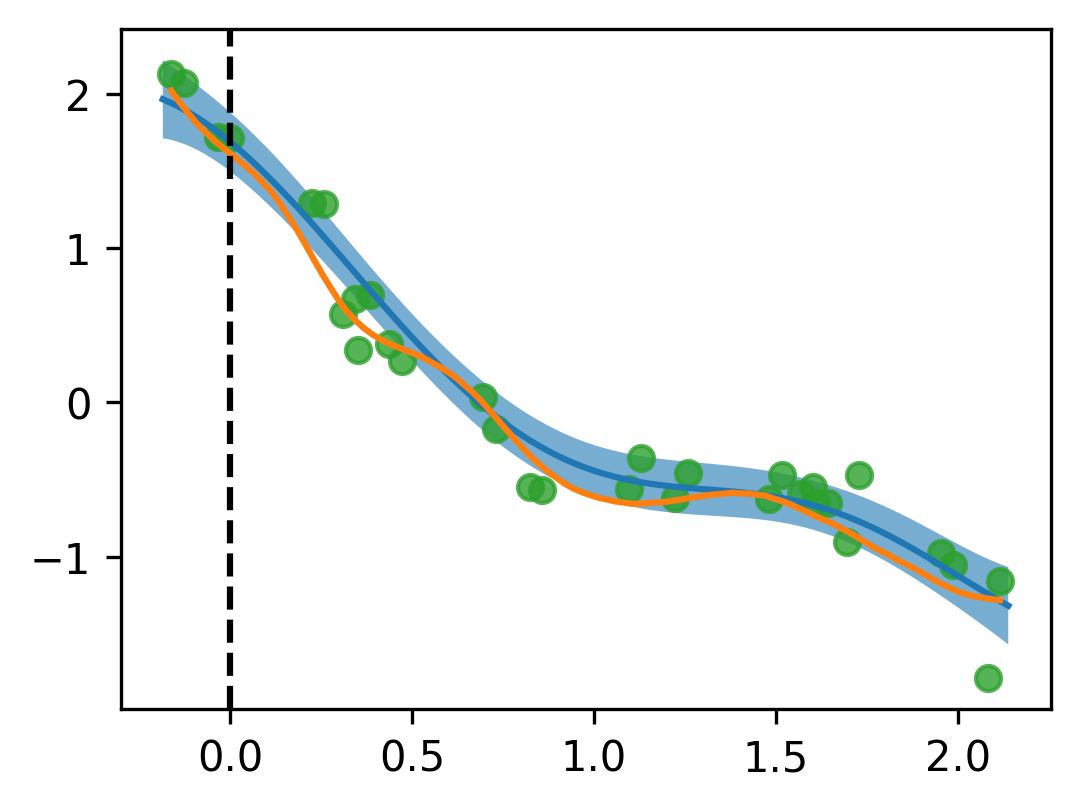

In [16]:
with torch.no_grad():
    
    Zapprox = basis(X)
    
    Zpred = torch.zeros(100, K)
    Zpred[:, z1] = torch.linspace(Zapprox[:, z1].min(), Zapprox[:, z1].max(), 100)

    fpred = surface(Zpred)
    
    lo, hi = fpred.confidence_region()
    
plt.figure(figsize=(4, 3), dpi=300)

plt.plot(Zpred[:, z1].numpy(), fpred.mean.numpy())
plt.fill_between(Zpred[:, z1].numpy(), lo.numpy(), hi.numpy(), alpha=0.6)

scale = Zapprox[:, z1].mean() / z.mean()
plt.plot(Z*scale, (f - y.mean())/y.std())
plt.scatter(z*scale, (y - y.mean())/y.std(), c="C2", alpha=0.8)
plt.axvline(0, c="k", ls="--")

None